In [42]:
from dataclasses import dataclass
import itertools
import logging
import random
import math
import numpy as np
import json
import pickle
import time
import torch
import sys
import pdb
import os
from matplotlib import pyplot as plt

from omegaconf import OmegaConf
from pathlib import Path
from torch import nn, Tensor
from torch.nn import functional as F
from typing import List, Optional, Tuple

from data import *
from model import ModelArgs, Transformer
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def iterate_beta(beta_0, ep_eps, varp_eps, lr=0.1):
    beta = beta_0
    while True:
        grad = ep_eps + (varp_eps - ep_eps) / (1 / beta + ep_eps)
        beta = beta - lr * grad
        yield beta

In [3]:
betas = iterate_beta(1, 0.02, 0.03, lr=1)
train_steps = 2000
betas_traj = []
for idx, beta in enumerate(betas):
    betas_traj.append(beta)
    if idx > train_steps:
        break

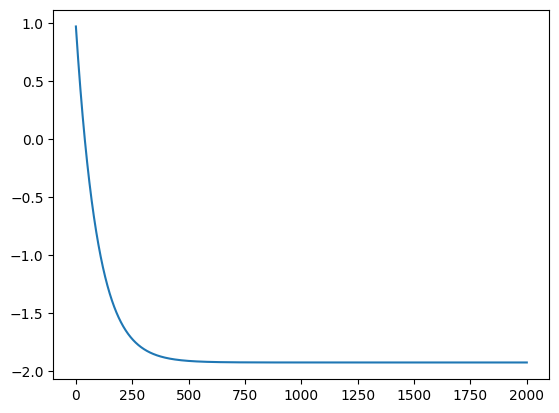

In [4]:
from matplotlib import pyplot as plt
plt.plot(betas_traj)

## Simulate the logits (attention sink)

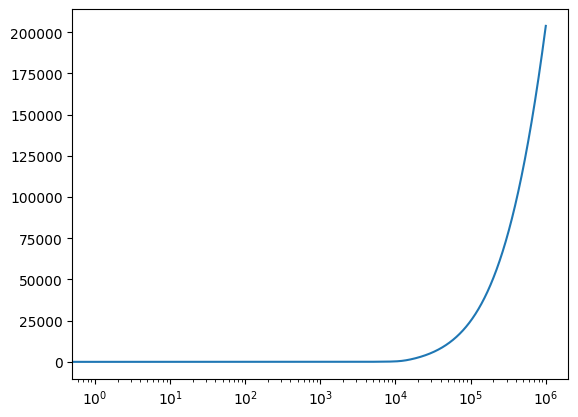

In [5]:
def iterate_y(y0, beta1, beta2, eps, lr):
    y = y0
    t = 1
    g, v = 0, 0
    while True:
        # dy = math.exp(-y)
        dy = 1 / t / 100
        g = beta1*g + (1-beta1)*dy
        v = beta2*v + (1-beta2)*dy**2
        g_scale = g / (1 - beta1**t)
        v_scale = v / (1 - beta2**t)
        update = lr * g_scale / (v_scale**0.5 + eps)
        # update = lr * dy
        y = y + update
        t += 1
        yield y, update, g_scale, v_scale
ys = iterate_y(0, 0.9, 0.999, 1e-8, 0.3)
train_steps = 1000000
ys_traj, updates_traj, gs_traj, vs_traj = [], [], [], []
for idx, (y, u, g, v) in enumerate(ys):
    ys_traj.append(y)
    updates_traj.append(u)
    gs_traj.append(g)
    vs_traj.append(v)
    if idx > train_steps:
        break
from matplotlib import pyplot as plt
plt.plot(ys_traj[:])
plt.gca().set_xscale('log')


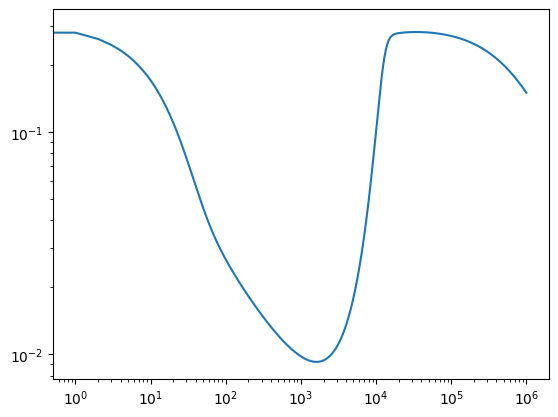

In [6]:
plt.plot(updates_traj[:])
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')

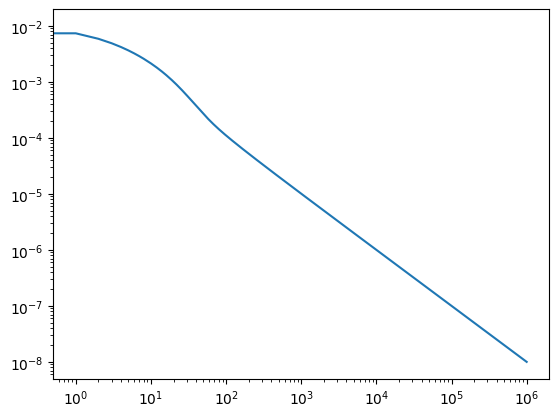

In [4]:
plt.plot(gs_traj[:])
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')

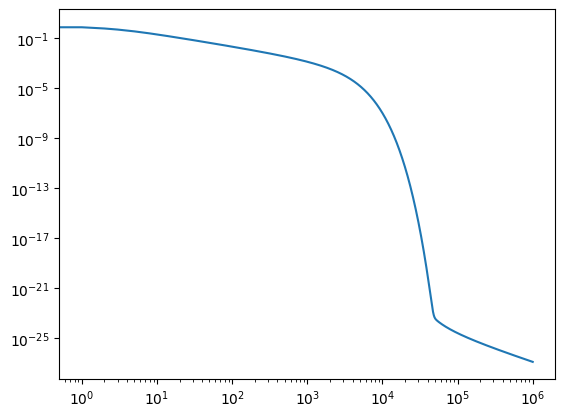

In [32]:
plt.plot(vs_traj[:])
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')

## Simulate the massive norm

In [44]:
def iterate_m(m0, beta1, beta2, eps, lr):
    m = m0
    m_sgd = m0
    t = 1
    g, v = 0, 0
    while True:
        dm = math.log(t) / m**3 / t
        g = beta1*g + (1-beta1)*dm
        v = beta2*v + (1-beta2)*dm**2
        g_scale = g / (1 - beta1**t)
        v_scale = v / (1 - beta2**t)
        udpate = lr * g_scale / (v_scale**0.5 + eps)
        m = m + udpate
        m_sgd = m_sgd + lr * dm
        t += 1
        yield m, m_sgd, udpate

In [45]:
ms = iterate_m(10, 0.9, 0.999, 1e-8, 0.3)
train_steps = 10000
ms_traj = []
udpates_traj = []
m_sgd_traj = []
for idx, (m, m_sgd, u) in enumerate(ms):
    ms_traj.append(m)
    m_sgd_traj.append(m_sgd)
    udpates_traj.append(u)
    if idx > train_steps:
        break


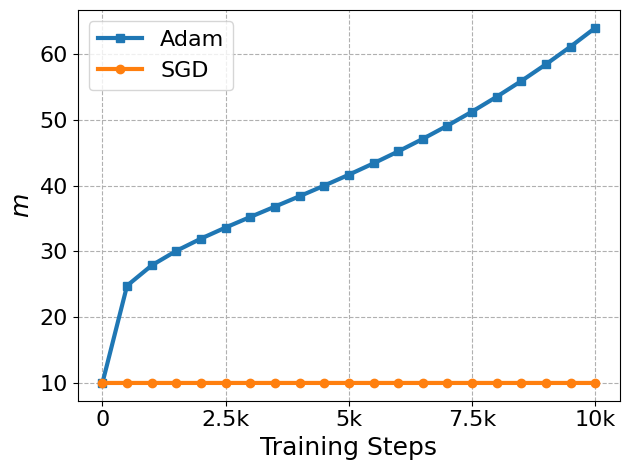

In [48]:
from matplotlib import pyplot as plt
dir_name = "~/figures/BBM"
x = np.arange(1, len(ms_traj)+1)
step_size = 500
fig, ax = plt.subplots()
ax.plot(x[::step_size], ms_traj[::step_size], label='Adam', marker = 's', lw=3)
ax.plot(x[::step_size], m_sgd_traj[::step_size], label='SGD', marker = 'o', lw=3)
ax.set_xticks([0, 2500, 5000, 7500, 10000])
ax.set_xticklabels(['0', '2.5k', '5k', '7.5k', '10k'], fontsize=16)
ax.grid(linestyle='--')
ax.set_xlabel('Training Steps', fontsize=18)
ax.set_ylabel(r'$m$', fontsize=18)
ax.legend(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(dir_name, "m_dynamics.pdf"), bbox_inches='tight')
plt.show()

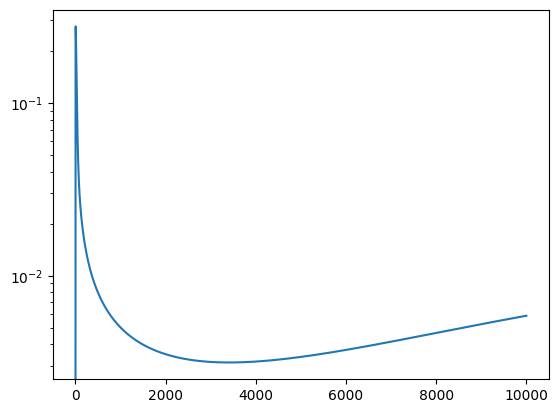

In [16]:
plt.plot(udpates_traj)
plt.gca().set_yscale('log')
plt.show()

## put m and y together

In [26]:
class adam():
    def __init__(self, beta1, beta2, eps, lr, wd, warm_up):
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.lr = lr
        self.t = 1
        self.g = 0
        self.v = 0
        self.wd = wd
        self.warm_up = warm_up
    def forward(self, x, grad, t, ):
        x = x - self.lr * self.wd * x
        self.g = self.beta1 * self.g + (1 - self.beta1) * grad
        self.v = self.beta2 * self.v + (1 - self.beta2) * grad**2
        g_scale = self.g / (1 - self.beta1**t)
        v_scale = self.v / (1 - self.beta2**t)
        if t > self.warm_up:
            update = - self.lr * g_scale / (v_scale**0.5 + self.eps)
        else:
            update = - self.lr * g_scale
        x = x + update
        return x, update, g_scale, v_scale
def func_grad(y, m, c, t):
    norm = (m + c) / math.sqrt(m**2 + 2*m*c + 1)
    coeff = 1
    dy = -coeff * math.exp(- (y * norm)) * norm
    dm = -coeff * math.exp(- (y * norm)) * y * (1 - c**2)  / (m**2 + 2*m*c + 1)**1.5
    return dy, dm, t
def iterate_sgd(y0, m0, c, lr, wd):
    y, m= y0, m0
    t = 1
    while True:
        dy, dm, t = func_grad(y, m, c, t)
        y = y - lr * dy
        m = m - lr * dm
        t += 1
        y_sgd = {'value': y, 'd': dy}
        m_sgd = {'value': m, 'd': dm}
        yield y_sgd, m_sgd

def iterate_adam(y0, m0, c, beta1, beta2, eps, lr, wd, warm_up):
    y, m = y0, m0
    t = 1
    adam_y = adam(beta1, beta2, eps, lr, wd, warm_up)
    adam_m = adam(beta1, beta2, eps, lr, wd, warm_up)
    while True:
        dy, dm, t = func_grad(y, m, c, t)
        y, y_update, y_g_scale, y_v_scale = adam_y.forward(y, dy, t)
        m, m_update, m_g_scale, m_v_scale = adam_m.forward(m, dm, t)
        t += 1
        y_adam = {'value': y, 'd': dy, 'update': y_update, 'g_scale': y_g_scale, 'v_scale': y_v_scale}
        m_adam = {'value': m, 'd': dm, 'update': m_update, 'g_scale': m_g_scale, 'v_scale': m_v_scale}
        yield y_adam, m_adam

In [27]:
y_sgd = {'value': [], 'd': []}
m_sgd = {'value': [], 'd': []}
sgd_iter = iterate_sgd(0, 1, 0.2, 0.1, 0.01)
y_adam = {'value': [], 'd': [], 'update': [], 'g_scale': [], 'v_scale': []}
m_adam = {'value': [], 'd': [], 'update': [], 'g_scale': [], 'v_scale': []}
adam_iter = iterate_adam(0.5, 0.5, 0.5, 0.9, 0.999, 1e-8, 0.8, 0.0001, 0)

In [28]:
train_steps = 20000
for idx, values in enumerate(adam_iter):
    for key in y_adam.keys():
        y_adam[key].append(values[0][key])
        m_adam[key].append(values[1][key])
    if idx > train_steps:
        break

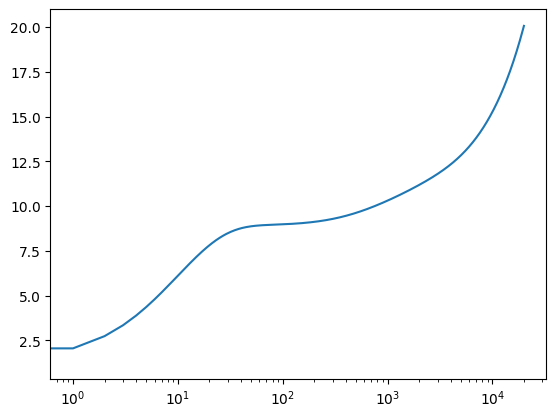

In [29]:
plt.plot(y_adam['value'][:])
# plt.plot(-np.array(y_adam['d']))
# plt.plot(np.array(y_adam['update']))
plt.gca().set_xscale('log')
# plt.gca().set_yscale('log')
plt.show()

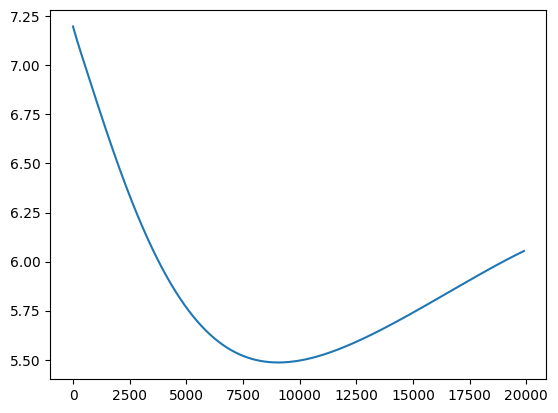

In [30]:
plt.plot(m_adam['value'][100:])
# plt.gca().set_xscale('log')
plt.show()

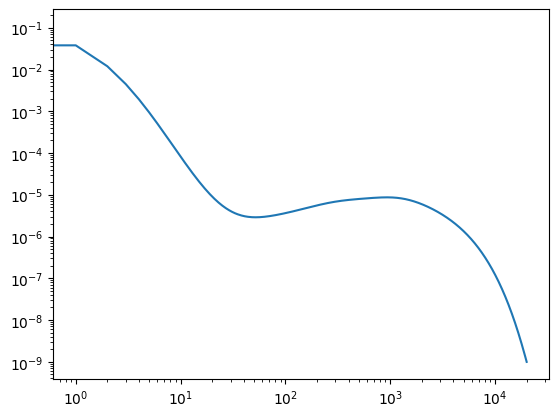

In [25]:
# plt.plot(np.array(m_adam['update']))
plt.plot(-np.array(m_adam['d']))
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.show()

## decouple y

In [262]:
class adam():
    def __init__(self, beta1, beta2, eps, lr):
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.lr = lr
        self.t = 1
        self.g = 0
        self.v = 0
    def forward(self, x, grad, t, ):
        self.g = self.beta1 * self.g + (1 - self.beta1) * grad
        self.v = self.beta2 * self.v + (1 - self.beta2) * grad**2
        g_scale = self.g / (1 - self.beta1**t)
        v_scale = self.v / (1 - self.beta2**t)
        update = - self.lr * g_scale / (v_scale**0.5 + self.eps)
        x = x + update
        return x, update, g_scale, v_scale
def func_grad(k, q, m, r, c, t):
    norm = (m*r + c) / math.sqrt(m**2 * r**2 + 2*m*r*c + 1)
    coeff = 1
    dk = -coeff * math.exp(- (k*q * (norm+1))) * (norm+1) * q
    dq = -coeff * math.exp(- (k*q * (norm+1))) * (norm+1) * k
    dm = -coeff * math.exp(- (k*q * (norm+1))) * k*q * (1 - c**2) * r / (m**2 * r**2 + 2*m*r*c + 1)**1.5
    dr = -coeff * math.exp(- (k*q * (norm+1))) * k*q * (1 - c**2) * m / (m**2 * r**2 + 2*m*r*c + 1)**1.5
    return dk, dq, dm, dr, t
def iterate_sgd(k0, q0, m0, r0, c, lr):
    q, k, m, r = k0, q0, m0, r0
    t = 1
    while True:
        dk, dq, dm, dr, t = func_grad(k, q, m, r, c, t)
        k = k - lr * dk
        q = q - lr * dq
        m = m - lr * dm
        r = r - lr * dr
        t += 1
        k_sgd = {'value': k, 'd': dk}
        q_sgd = {'value': q, 'd': dq}
        m_sgd = {'value': m, 'd': dm}
        r_sgd = {'value': r, 'd': dr}
        yield k_sgd, q_sgd, m_sgd, r_sgd

def iterate_adam(k0, q0, m0, r0, c, beta1, beta2, eps, lr):
    k, q, m, r = k0, q0, m0, r0
    t = 1
    adam_k = adam(beta1, beta2, eps, lr)
    adam_q = adam(beta1, beta2, eps, lr)
    adam_m = adam(beta1, beta2, eps, lr)
    adam_r = adam(beta1, beta2, eps, lr)
    while True:
        dk, dq, dm, dr, t = func_grad(k, q, m, r, c, t)
        k, k_update, k_g_scale, k_v_scale = adam_k.forward(k, dk, t)
        q, q_update, q_g_scale, q_v_scale = adam_q.forward(q, dq, t)
        m, m_update, m_g_scale, m_v_scale = adam_m.forward(m, dm, t)
        r, r_update, r_g_scale, r_v_scale = adam_r.forward(r, dr, t)
        t += 1
        k_adam = {'value': k, 'd': dk, 'update': k_update, 'g_scale': k_g_scale, 'v_scale': k_v_scale}
        q_adam = {'value': q, 'd': dq, 'update': q_update, 'g_scale': q_g_scale, 'v_scale': q_v_scale}
        m_adam = {'value': m, 'd': dm, 'update': m_update, 'g_scale': m_g_scale, 'v_scale': m_v_scale}
        r_adam = {'value': r, 'd': dr, 'update': r_update, 'g_scale': r_g_scale, 'v_scale': r_v_scale}
        yield k_adam, q_adam, m_adam, r_adam

In [263]:
k_adam = {'value': [], 'd': [], 'update': [], 'g_scale': [], 'v_scale': []}
q_adam = {'value': [], 'd': [], 'update': [], 'g_scale': [], 'v_scale': []}
m_adam = {'value': [], 'd': [], 'update': [], 'g_scale': [], 'v_scale': []}
r_adam = {'value': [], 'd': [], 'update': [], 'g_scale': [], 'v_scale': []}
adam_iter = iterate_adam(0.5, 0.5, 0.5, 0.5, 0.5, 0.9, 0.999, 1e-8, 0.0003)

In [264]:
train_steps = 100000
for idx, values in enumerate(adam_iter):
    for key in k_adam.keys():
        k_adam[key].append(values[0][key])
        q_adam[key].append(values[1][key])
        m_adam[key].append(values[2][key])
        r_adam[key].append(values[3][key])
    if idx > train_steps:
        break

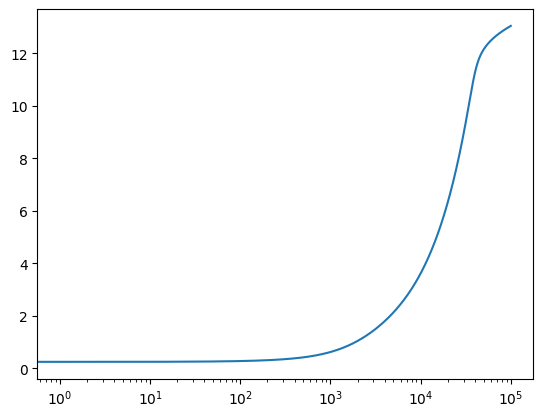

In [267]:
plt.plot(np.array(q_adam['value']) * np.array(k_adam['value']))
# plt.plot(-np.array(y_adam['d']))
plt.gca().set_xscale('log')
# plt.gca().set_yscale('log')
plt.show()

## check the gd of the fully simplified model

In [130]:
def g_loss(y, s, p, zb, w, pi):
    zs = s * w
    logit_q = torch.exp(y).outer(s) / (torch.exp(y) + w).unsqueeze(-1) + (1 / (torch.exp(y) + w)).outer(zb) + p.log()
    q = torch.functional.F.softmax(logit_q, dim=-1)
    diff_y = (q - p) @ (zb - zs) * pi
    diff_s = (q - p).T @ (torch.exp(y) / (torch.exp(y) + w) * pi)
    g_y = - torch.exp(y) / (torch.exp(y) + w)**2 * diff_y
    g_s = diff_s
    return g_y, g_s

def loss(y, s, p, zb, w, pi):
    zs = s * w
    logit_q = torch.exp(y).outer(s) / (torch.exp(y) + w).unsqueeze(-1) + (1 / (torch.exp(y) + w)).outer(zb) + p.log()
    q = torch.functional.F.softmax(logit_q, dim=-1)
    return - torch.sum(torch.sum(p * torch.log(q), dim=-1) * pi) + torch.sum(torch.sum(p * torch.log(p), dim=-1) * pi)

def iterate(y0, s0, p, zb, w, pi, lr, fix_s=False, fix_y=False):
    y, s = y0, s0
    if fix_s:
        s = torch.ones_like(s0)
    t = 1
    while True:
        g_y, g_s = g_loss(y, s, p, zb, w, pi)
        l = loss(y, s, p, zb, w, pi)
        if not fix_y:
            y = y - lr * g_y
        if not fix_s:
            s = s - lr * g_s
        t += 1
        yield y, s, l

In [131]:
L = 10
n = 3
p = torch.rand(n, L)
p = p / p.sum(dim=-1, keepdim=True)
pi = torch.rand(n)
pi = pi / pi.sum()
zb = torch.rand(L) * 10
w = 10
lr = 1
y0 = torch.rand(n)
s0 = torch.randn(L)
gd_traj = iterate(y0, s0, p, zb, w, pi, lr)

In [132]:
ys_traj = []
ss_traj = []
ls_traj = []
for idx, (y, s, l) in enumerate(gd_traj):
    ys_traj.append(y)
    ss_traj.append(s)
    ls_traj.append(l)
    if idx > 10000:
        break
ss_traj = torch.stack(ss_traj)
ys_traj = torch.stack(ys_traj)
ls_traj = torch.stack(ls_traj)

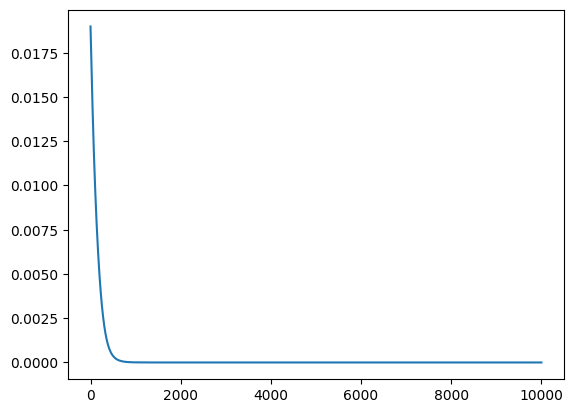

In [133]:
plt.plot(ls_traj)

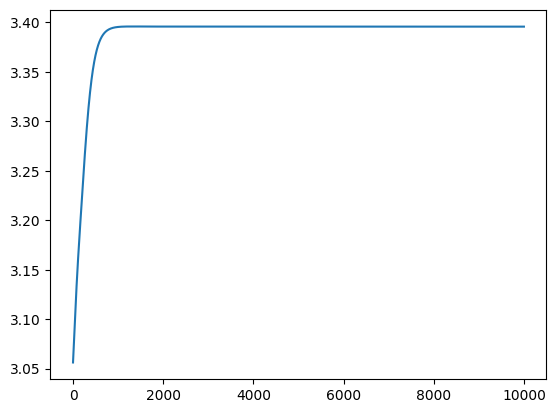

In [140]:
plt.plot(ss_traj.norm(dim=-1))

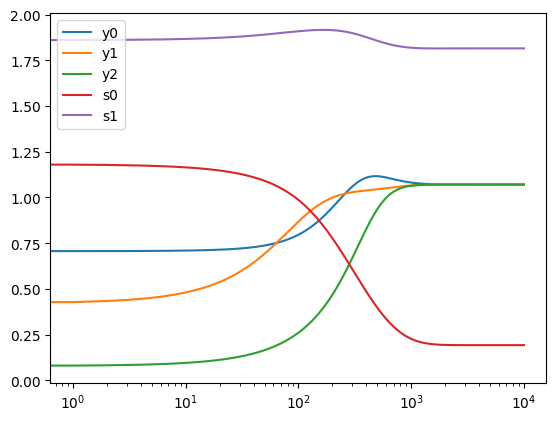

In [139]:
plt.plot(ys_traj[:, 0], label='y0')
plt.plot(ys_traj[:, 1], label='y1')
plt.plot(ys_traj[:, 2], label='y2')


plt.plot(ss_traj[:, 0], label='s0')
plt.plot(ss_traj[:, 1], label='s1')
plt.gca().set_xscale('log')
plt.legend()
plt.show()